# Best reward experiment

Analysis of the best reward function for the LTI citation.
Comparison uses TD3, SAC, and DSAC with three different reward functions:
1. $r=e$
1. $r= e + \Delta u$
1. $r= e + \Delta u + u$

In [13]:
import pandas as pd
from helpers.paths import Path
import seaborn as sns

sns.set()

## 1. Tracking sinusoidal pitch rate

### Analusis of tracking error

Load and clean data:

In [17]:
# Load data
df = pd.read_csv(Path.data/"best_reward.csv")

# Assert tracking error is available for all data
print("Missing tracking data" if df[df.tracking_error.isna()].any().any() else "Every run contains tracking_error field.")

# Group data from a single run
df = df.groupby(["run", "algorithm", "reward_type"]).aggregate({"tracking_error": "mean", 
                                                                "episode_step": "count"
                                                               }).reset_index()

# Rename reward_types
df = df.replace({"reward_type":{
    'sq_error': r'$e$',
    'sq_error_da': r'$e + \Delta u$',
    'sq_error_da_a': r'$e + \Delta u + u$',
}})

display(df.head())

Every run contains tracking_error field.


,run,algorithm,reward_type,tracking_error,episode_step
0,amber-disco-33,DSAC,$e + \Delta u$,0.012693,100
1,amber-forest-51,TD3,$e + \Delta u$,0.001662,100
2,amber-vortex-196,DSAC,$e$,0.014421,100
3,apricot-bee-205,DSAC,$e + \Delta u$,0.005363,100
4,astral-bee-94,TD3,$e + \Delta u + u$,0.017878,100


Check if all algorithms have the same amount of episodes

In [16]:
display(df.groupby("algorithm")["algorithm"].count())
display(df.describe())

algorithm
DSAC    60
SAC     60
TD3     59
Name: algorithm, dtype: int64

,tracking_error,episode_step
count,179.000000,179.0
mean,0.007985,100.0
std,0.009691,0.0
min,0.000135,100.0
25%,0.002637,100.0
50%,0.005123,100.0
75%,0.010063,100.0
max,0.056297,100.0


Some episodes do not last unitil the end. Remove those episodes:

In [11]:
# Keep only episodes that are long enough
df = df[df.episode_step==100]

<AxesSubplot: xlabel='algorithm', ylabel='tracking_error'>

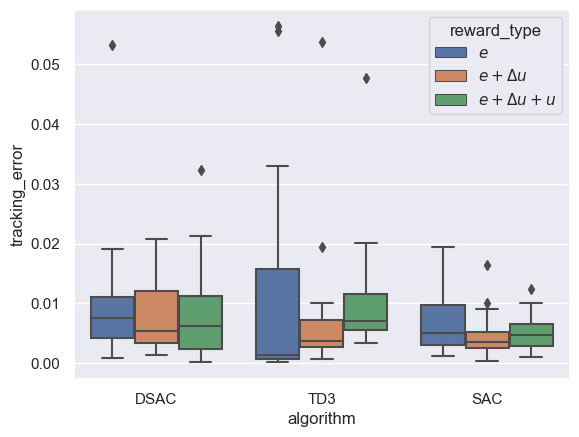

In [12]:
hue_order = ["$e$", "$e + \Delta u$", "$e + \Delta u + u$"]
sns.boxplot(data=df, x="algorithm", y="tracking_error", hue="reward_type", hue_order=hue_order)

### Episode length analysis

In [21]:
# Load data
df_rollout = pd.read_csv(Path.data/"best_reward_rollout.csv")

# Get runs
runs = df_rollout['run'].unique()

In [27]:
algorithm = "SAC"
for run in runs:
    df_temp = df_rollout[(df_rollout.run == run) & (df_rollout.algorithm == algorithm)]
df_temp

,Unnamed: 0,_step,rollout/ep_len_mean,rollout/ep_rew_mean,algorithm,reward_type,run
37807,0,0,8.000000,-42.260773,SAC,sq_error,laced-pond-14
37808,1,1,54.500000,-23.655102,SAC,sq_error,laced-pond-14
37809,2,2,57.000000,-22.361485,SAC,sq_error,laced-pond-14
37810,3,3,68.000000,-17.372065,SAC,sq_error,laced-pond-14
37811,4,4,74.599998,-14.271927,SAC,sq_error,laced-pond-14
...,...,...,...,...,...,...,...
37902,95,95,99.625000,-2.434353,SAC,sq_error,laced-pond-14
37903,96,96,99.639175,-2.424491,SAC,sq_error,laced-pond-14
37904,97,97,99.653061,-2.413381,SAC,sq_error,laced-pond-14
37905,98,214,99.666664,-2.403401,SAC,sq_error,laced-pond-14
